In [11]:
import pandas as pd
import numpy as np
import os, pdb, sys, pickle

np.random.seed(42)

df = pd.DataFrame({'x1': np.random.normal(loc=0, scale=1, size=1000),
                   'x2': np.random.normal(loc=0, scale=1, size=1000),
                   'x3': np.random.normal(loc=0, scale=1, size=1000),
                   'y': np.random.randint(0,2,size=1000)})

# Changes
chg = {} 

chgAmts = [0.001, 0.01, 0.1, 0.6, 1.0, 5, 10, 20, 30]

for c in chgAmts: 
    tmp = df.copy(deep = True)
    new = pd.DataFrame({'x1': np.random.normal(loc=0*c, scale=1*c, size=400),
                    'x2': np.random.normal(loc=0, scale=1, size=400),
                    'x3': np.random.normal(loc=0, scale=1, size=400),
                    'y': np.random.randint(0,2,size=400)})
    chg[c] = pd.concat([tmp, new])

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gudhi import RipsComplex, SimplexTree

res = {} 
for k in chg.keys(): 
    for w in [30]: 
        print("K: " + str(k))
        print("W: " + str(w))
        # Combine df and df_drifted
        df_combined = chg[k]

        # Generate a time index
        df_combined['time'] = np.arange(len(df_combined))

        # Create a function to compute persistence diagrams
        def compute_persistence_diagrams(data):
            rips_complex = RipsComplex(points=data)
            simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
            simplex_tree.persistence()
            persistence_intervals = simplex_tree.persistence_intervals_in_dimension(1)
            return persistence_intervals

        # Create a function to compute persistence entropy
        def compute_persistence_entropy(diagrams):
            entropies = []
            for diagram in diagrams:
                lifetimes = diagram[:, 1] - diagram[:, 0]
                lifetimes = lifetimes[lifetimes > 0]
                if len(lifetimes) > 0:
                    p = lifetimes / lifetimes.sum()
                    entropy = -np.sum(p * np.log(p))
                else:
                    entropy = 0
                entropies.append(entropy)
            return entropies

        # Compute persistence entropy over time
        entropy_values = []

        for start in range(len(df_combined) - w + 1):
            window_data = df_combined[['x1', 'x2', 'x3']].iloc[start:start + w].values
            persistence_diagrams = [compute_persistence_diagrams(window_data)]
            entropy_value = compute_persistence_entropy(persistence_diagrams)[0]
            entropy_values.append(entropy_value)
        df_combined['pe'] = [0]*(w-1) + entropy_values
        dfc = df_combined.copy(deep = True)
        res[str(k) + '-' + str(w)] = dfc

K: 0.001
W: 30
K: 0.01
W: 30
K: 0.1
W: 30
K: 0.6
W: 30
K: 1.0
W: 30
K: 5
W: 30
K: 10
W: 30
K: 20
W: 30
K: 30
W: 30


In [13]:
import pickle
with open('results.pkl', 'wb') as f: 
    pickle.dump(res, f)
    

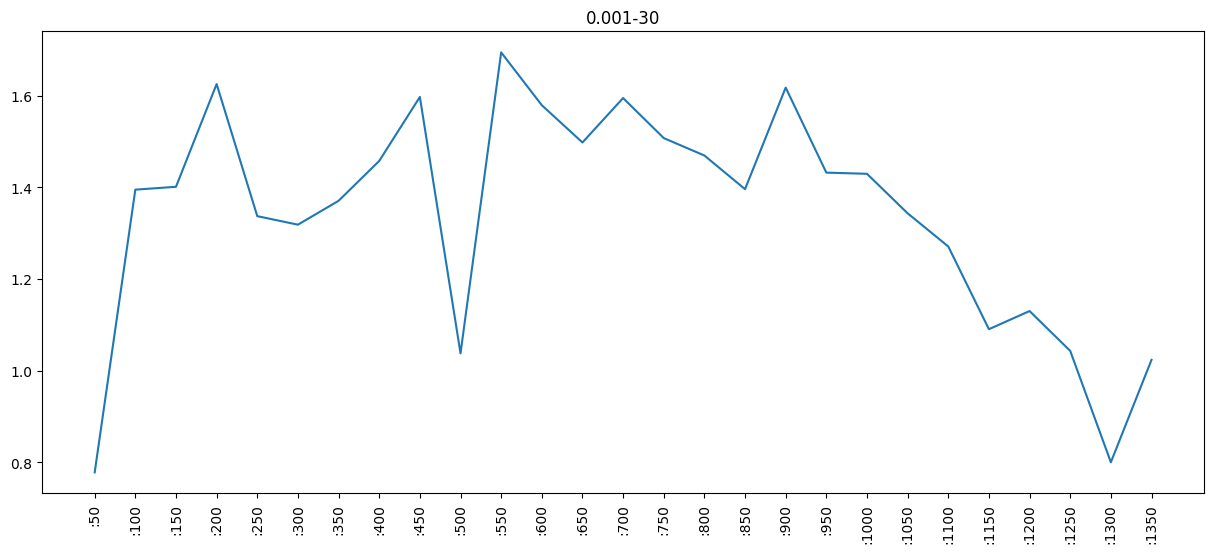

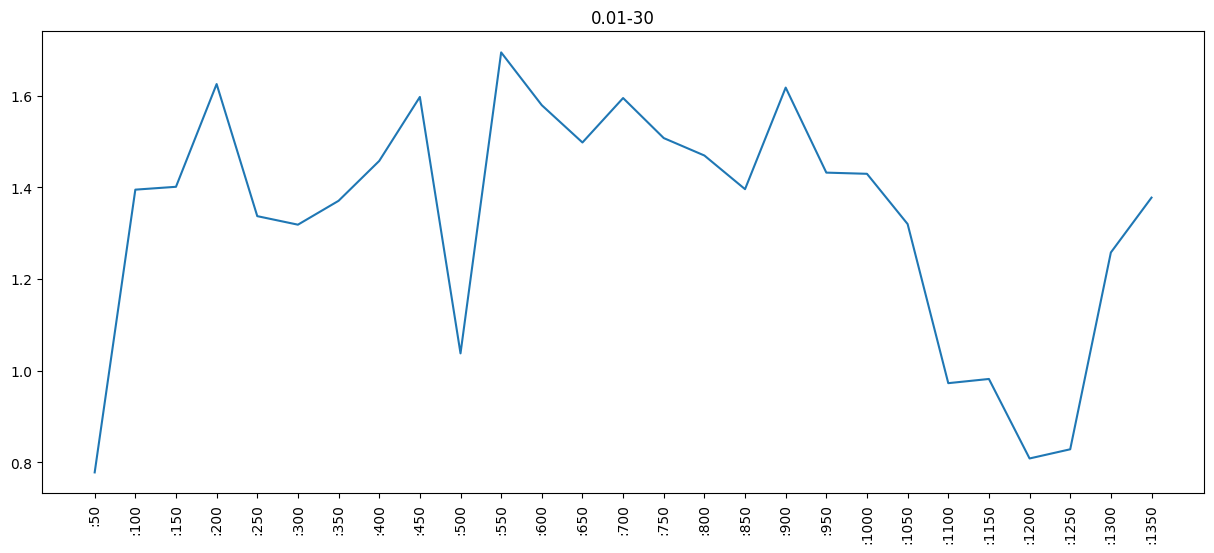

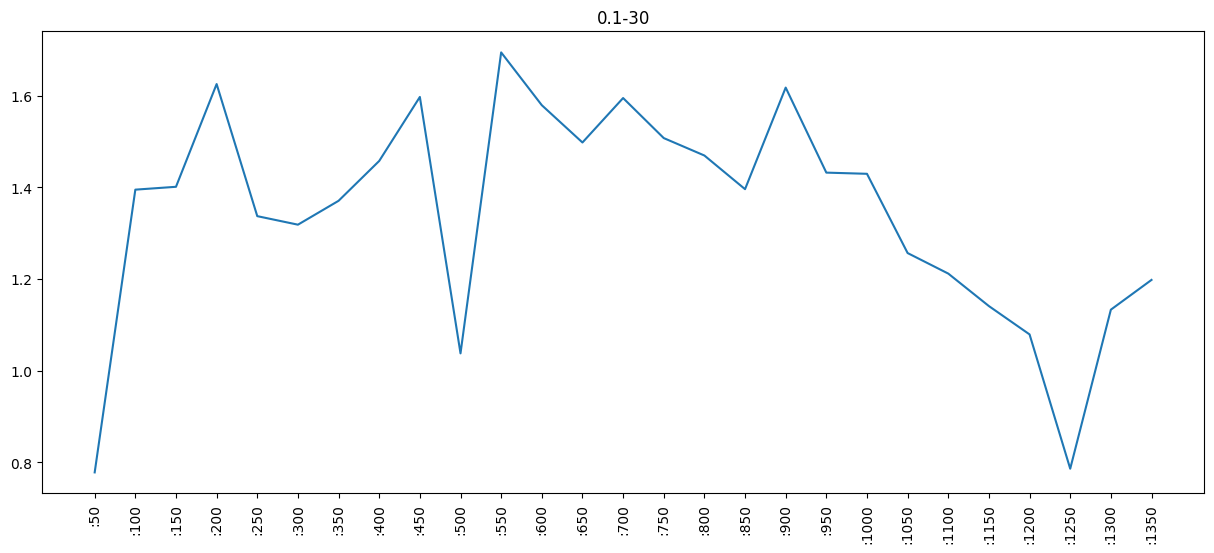

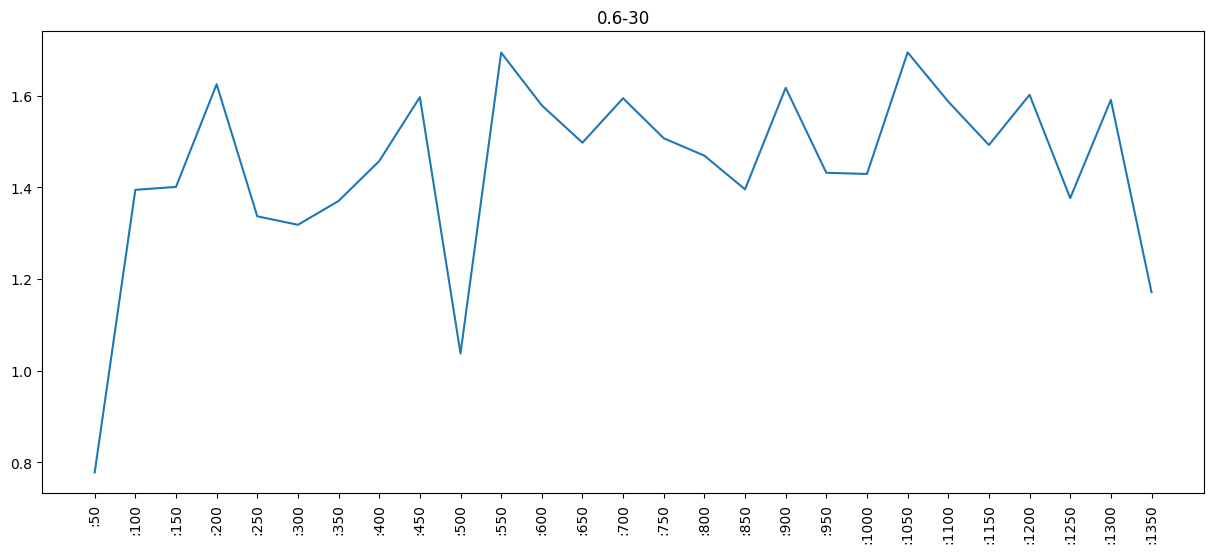

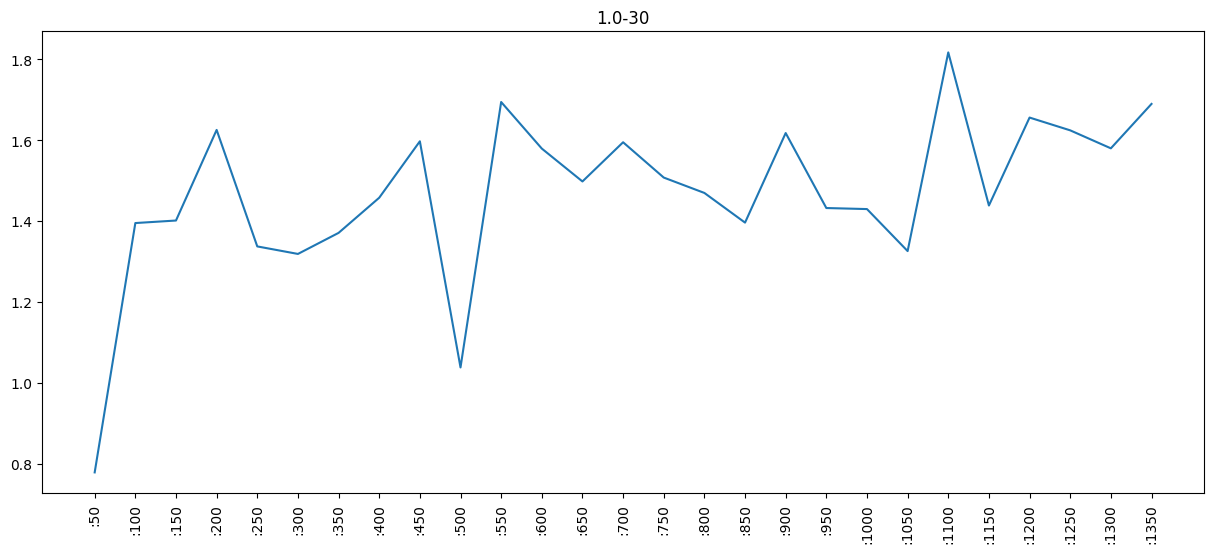

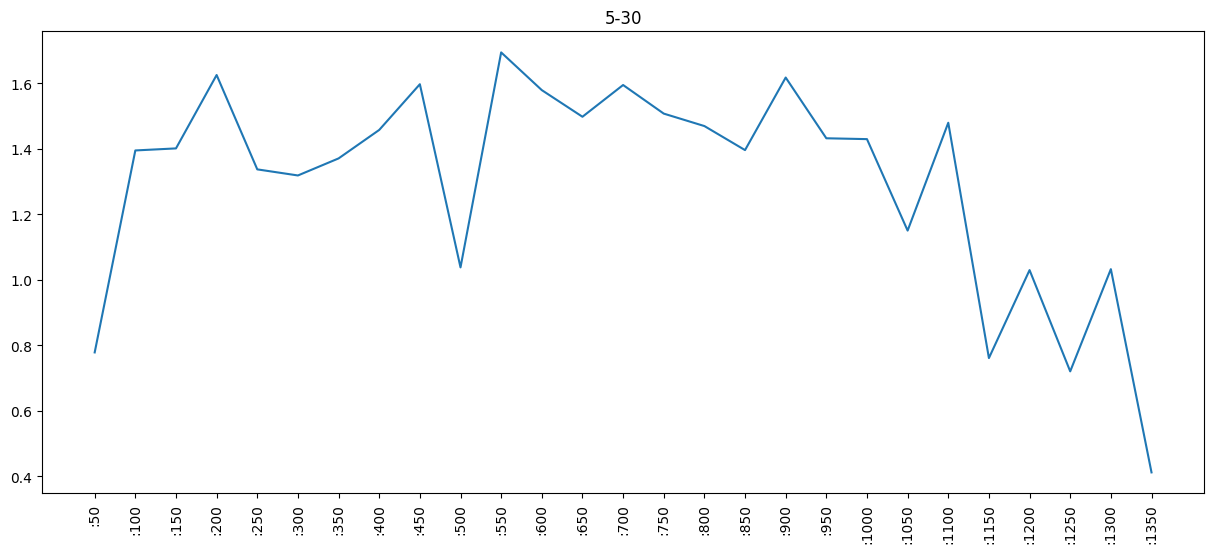

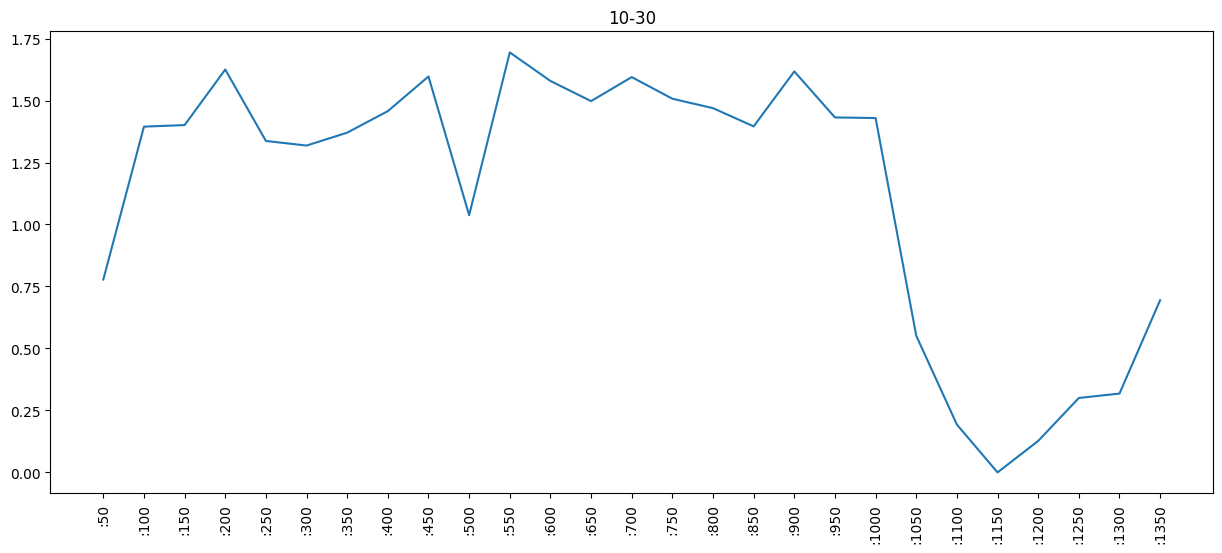

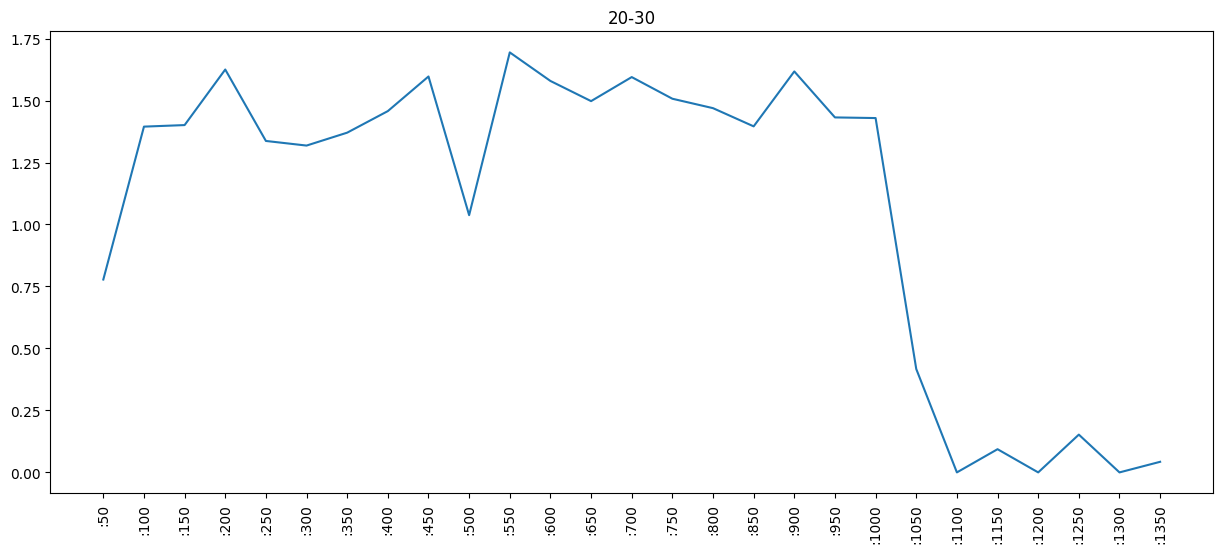

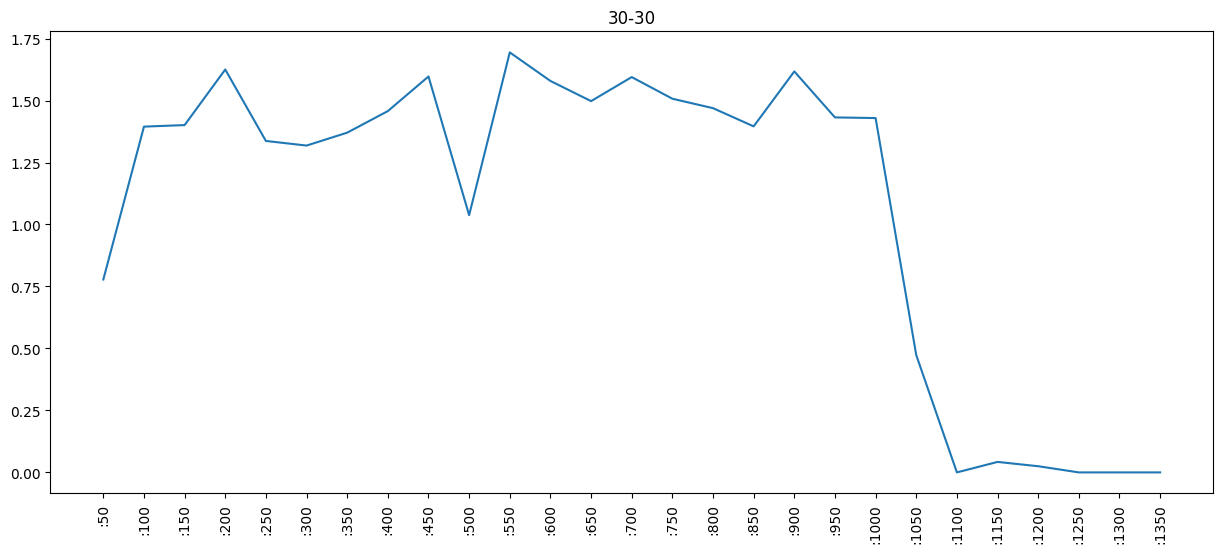

In [14]:
iter_val = 50
for_plots = {} 
for k in res.keys(): 
    sub = res[k]
    avgs, idx = [], []
    start, stop = 0, iter_val
    while stop < len(sub): 
        vals = list(sub['pe'])[start:stop]
        avgs.append(np.mean(vals))
        idx.append(':' + str(stop))
        start = stop
        stop += iter_val
    plt.figure(figsize=(15,6))
    plt.plot(range(len(avgs)), avgs, label = 'average_pe')
    plt.xticks(range(len(avgs)), [i if int(i.split(':')[-1])%50 == 0 else '' for i in idx], rotation = 90)
    plt.title(k)
    plt.show()
    for_plots[k] = {'idx': idx, 'avgs': avgs}

In [15]:
for k in for_plots.keys(): 
    sub = for_plots[k]
    pd.DataFrame(sub).to_csv(k + 'trends.csv', index = None)